In [14]:
#exploring with the blocks paradigm
#let us see!

#pamop @nyu.edu
#sept 2018

# imports
from random import randint
import numpy as np
import random
import datetime # for limiting calculation to wall clock time
import math
import copy
import matplotlib.pyplot as plt
import pdb

In [3]:
#states. there are 13 (3 blocks, six stacks, six double-single groups, one where no groups)

S = [0,1,2,3,4,5,6,7,8,9,10,11,12]
StateNames = ['r,g,b','r,gb','r,bg','g,rb','g,br','b,rg','b,gr','rgb','rbg','grb','gbr','brg','bgr']
C = [0,1,2]
Colors = ['red','green','blue']

#0 r, g, b
#1 r,gb
#2 r,bg
#3 g,rb
#4 g,br
#5 b,rg
#6 b,gr
#7 rgb
#8 rbg
#9 grb
#10 gbr
#11 brg
#12 bgr


In [56]:
#actions. there are 18 (3 categories of actions, 6 actions in each category)

A = [0,1,2]
Actions = ["Put x on y.", "Take x off y.", "Is x on y?"]


In [57]:
# build action string
def act_str(a,c1,c2):
    Colors = ['red','green','blue']
    assert c1 < len(Colors) and c2 < len(Colors), "One of the color indices is outside the size of Colors matrix. See act_str method."
    c1 = Colors[c1]
    c2 = Colors[c2]
    if a == 0 or a == "Put x on y.":
        astr = "Put " + c1 + " on " + c2 + "."
    elif a == 1 or a == "Take x off y.":
        astr = "Take " + c1 + " off " + c2 + "."
    elif a == 2 or a == "Is x on y?":
        astr = "Is " + c1 + " on " + c2 + "?"
    else:
        raise ValueError("Invalid action input when trying to build action string. See act_str method.")
    return astr

In [58]:
#observations. there are 2

O = [0,1]
Observations = ['no','yes']

In [59]:
#transitions.

T = np.zeros([len(S),len(S),len(A)])
T_putaction = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [4]:
#transitions
# in form of a transition function: 

class BlockGame():
    def __init__(self,target):
        self.Actions = ["Put x on y.", "Take x off y.", "Is x on y?", "Final test"]
        self.ActBrief = ["put","take","ask","test"]
        self.Observations = ['no','yes']
        self.Colors = ['red','green','blue']
        self.ColorsShort = ['r','g','b']
        self.StateNames = ['r,g,b','r,gb','r,bg','g,rb','g,br','b,rg','b,gr','rgb','rbg','grb','gbr','brg','bgr']
        # reward dynamics:
        self.ActionCost = -1
        self.CorrectRwd = 100
        self.IncorrectRwd = -80
        self.IllegalActionPenalty = 5
        
        self.target = target
#         if target in self.StateNames:
#             self.target = target
#         else:
#             raise Exception("Error initializing block game object: Target state must be a valid state.")
        
    # transitition function
    # state is 0 to 12
    def next_state(self, state, action):    
        # check action to end game
        if action == 3 or action[0]==2: # ask or check
            return state 
        
        # if you chose an "illegal" action, the state doesn't change (just a time penalty in rwd function)
        if action not in self.legal_actions_state(state):
            return state
        
        # actions should look like: [0,'r','g'] for Put red on green, [1,'b','r'] for Take blue off red, etc.
        assert action[1] in ['r','b','g'], 'Err in next_state function: invalid action color labels'
        assert action[2] in ['r','b','g'], 'Err in next_state function: invalid action color labels'
        
        # index of colors x and y in state name
        s = self.StateNames[state]
        x = s.index(action[1])
        y = s.index(action[2])
        
#         if action[0]==2: # ask: is x on y
#             return state
        if action[0]==1: # take x off y
            if len(s)==4: # e.g., 'a,bc'
                return 0 #'r,g,b' #state[:x] + ',' + state[y] # put a comma between x and y ## ACTUALLY this should be :1 and 2 really
            elif len(s)==3: # e.g., 'xyz' 
                # note that legal actions (above) should only pass through cases of taking first off of second here
                return self.StateNames.index(s[0] + ',' + s[1:])
            else:
                raise Exception('Can only legally take a block off another block if length of state string is 3 or 4')
        elif action[0]==0: # put x on y
            if len(s)==5:
                # gotta handle this more specially because there are all possible "put" options
                allcolors = set(['r','g','b'])
                allcolors.remove(action[1])
                allcolors.remove(action[2])
                solocolor = allcolors.pop() # so now we know which one is left out
                return self.StateNames.index(solocolor + ',' + action[1] + action[2])
            elif len(s)==4:
                # remove the comma (remember, only legal actions being handled here)
                return self.StateNames.index(s[0] + s[2:]) # NO MORE COMMA
            else:
                raise Exception('Can only put a block on another block if length of state string is 4 or 5')
        else:
            raise Exception('Err in next_state fxn: First value in action should be 0, 1, or 2.')
    
    
    # observation function
    def observation(self, state, action):
        s = self.StateNames[state]
        if action == 3:
            return []
        elif action[0] == 2: # ask is x on y
            if s.index(action[2]) - s.index(action[1]) == 1: # if they are x is just left of y,
                return 1
            else:
                return 0 # should these be true / false? 'yes' 'no' ? shouldn't really matter besides what's convenient
        elif action[0] == 1:
            return []
        elif action[0] == 0:
            return []
        
    def reward(self, state, action):
        done = False
        
#         punishment for choosing an illegal action 
        if action not in self.legal_actions_state(state):
            return self.IllegalActionPenalty*self.ActionCost, done
        
        if action == 3: # check
            done = True
            if self.StateNames[state] == self.target or self.StateNames[state] in self.target: #if correct
                return self.CorrectRwd, done
            else:
                return self.IncorrectRwd, done
        elif action[0] == 2: # ask is x on y
            return self.ActionCost, done
        elif action[0] == 1: # take x off y
            return self.ActionCost, done
        elif action[0] == 0: # put x on y
            return self.ActionCost, done
        
    # i could do this state by state? or try to parse the state string by color and commas
    def legal_actions_state(self,state):
        
        put_acts = [[0,'r','g'],[0,'r','b'],[0,'g','r'],[0,'g','b'],[0,'b','r'],[0,'b','g']]
        take_acts = [[1,'r','g'],[1,'r','b'],[1,'g','r'],[1,'g','b'],[1,'b','r'],[1,'b','g']]
        ask_acts = [[2,'r','g'],[2,'r','b'],[2,'g','r'],[2,'g','b'],[2,'b','r'],[2,'b','g']]
        check = [3] # submit for checking if correct
        
        # or could state as number instead of string, i'm not sure yet...
        if state==0: #self.StateNames[0]: # 'r,g,b'
            return put_acts + ask_acts + check
        elif state==1: #self.StateNames[1]: # 'r,gb'
            return [put_acts[0]] + [take_acts[3]] + ask_acts + check
        elif state==2: #self.StateNames[2]: # 'r,bg'
            return [put_acts[1]] + [take_acts[5]] + ask_acts + check
        elif state==3: #self.StateNames[3]: # 'g,rb'
            return [put_acts[2]] + [take_acts[1]] + ask_acts + check
        elif state==4: #self.StateNames[4]: # 'g,br'
            return [put_acts[3]] + [take_acts[4]] + ask_acts + check
        elif state==5: #self.StateNames[5]: # 'b,rg'
            return [put_acts[4]] + [take_acts[0]] + ask_acts + check
        elif state==6: #self.StateNames[6]: # 'b,gr'
            return [put_acts[5]] + [take_acts[2]] + ask_acts + check
        elif state==7: #self.StateNames[7]: # 'rgb'
            return [take_acts[0]] + ask_acts + check
        elif state==8: #self.StateNames[8]: # 'rbg'
            return [take_acts[1]] + ask_acts + check
        elif state==9: #self.StateNames[9]: # 'grb'
            return [take_acts[2]] + ask_acts + check
        elif state==10: #self.StateNames[10]: # 'gbr'
            return [take_acts[3]] + ask_acts + check
        elif state==11: #self.StateNames[11]: # 'brg'
            return [take_acts[4]] + ask_acts + check
        elif state==12: #self.StateNames[12]: # 'bgr'
            return [take_acts[5]] + ask_acts + check
        else:
            raise Exception("in legal_actions_state method, can't have a state besides the 13 allowed. State name is ",state)
            
    # this is wrong but fine
    def legal_actions(self,history):
        put_acts = [[0,'r','g'],[0,'r','b'],[0,'g','r'],[0,'g','b'],[0,'b','r'],[0,'b','g']]
        take_acts = [[1,'r','g'],[1,'r','b'],[1,'g','r'],[1,'g','b'],[1,'b','r'],[1,'b','g']]
        ask_acts = [[2,'r','g'],[2,'r','b'],[2,'g','r'],[2,'g','b'],[2,'b','r'],[2,'b','g']]
        check = [3] # submit for checking if correct
        return put_acts + take_acts + ask_acts + check
            
    def G_model(self,state,action):
        s = self.next_state(state,action)
        obs = self.observation(state,action)
        rwd, done = self.reward(state,action) # note that this should be more like immediate reward of state, not long-term?
        return s, obs, rwd, done
    
    # prior might be different on a given trial! come up with ways to manipulate this
    def sample_prior(self):
        return np.random.randint(13)
    
#     # i need to know what action "real_obs" was said yes or no to
#     def keep_particle(self, part, action, real_obs):
#         if real_obs == []:
#             return True
#         if self.Observation(part,action) == real_obs: # e.g., if real_obs consistent with obs function on this particle,
#             return True # good particle
#         else:
#             return False # bad particle because doesn't match what we see
        
#     # generate a new particle from one randomly sampled from current belief (e.g., could add a lil noise if desired)
#     def new_particle(self, part):
#         return self.sample_prior() # idk nothing fancy here yet

    def print_state(self,state):
        print(self.StateNames[state])
        return
        
        

In [5]:
class SearchTree(object):
    def __init__(self,visits=1,value=0):
        self.visits = visits
        self.value = value
        self.children=[]
        
        
class ActionNode(SearchTree):
    def __init__(self,action=None,visits=1,value=0):
        super().__init__(visits,value)
        self.action = action
        
        
class ObservationNode(SearchTree):
    def __init__(self,observation=[],visits=1,value=0,belief=[]):
        super().__init__(visits,value)
        self.observation = observation
        self.belief = belief
        
    def expand(self, legal_actions):
        for a in legal_actions:
            self.children += [ActionNode(a)]
            
        # upper confidence bound value for given node "child"
    def ucb(self, child): #maybe use index of child not object
#         print("self.visit=",self.visit," len of self.children=",len(self.children))
        logval = math.log(self.visits) #, len(self.children))
        div = logval / child.visits
        return math.sqrt(div)
    
    def next_hist(self,action,obs):
        act_child = next((c for c in self.children if c.action==action), None)
        assert act_child != None, "shouldn't you be expanded already?"
        assert isinstance(act_child, ActionNode), "action child should be an action node!"
        
        obs_child = next((c for c in act_child.children if c.observation == obs), None) 
        if obs_child is None:
            act_child.children += [ObservationNode(obs)]
#             print(act_child.children[0].observation)
            obs_child = next((c for c in act_child.children if c.observation == obs), None)     
        return obs_child

In [6]:
class POMCP:
    def __init__(self, 
                 game=BlockGame('rgb'),
                 discount=0.8,
                 explore=1,
                 epsilon=1e-7,
                 n_particles=100,
                 **kwargs):
        
#         self.context = {}
        self.game = game
        self.discount = discount
        self.epsilon = epsilon
        self.explore = explore
        self.n_particles = n_particles
        self.G = game.G_model      
        self.tree = [] #ObservationNode([]) 
        self.history = []
        # list of all possible actions
#         self.actions = kwargs.get('actions') 
        
        seconds = kwargs.get('time',30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.maxdepth = kwargs.get('maxdepth',20)
        self.nsims = kwargs.get('nsims',1000)
        
    def search(self,obs):
        
        self.history += [obs]
        
        if self.tree == []:
            print("tree is none")
            self.tree = ObservationNode(obs)                        
#             particle = self.game.sample_prior()
#             self.simulate(particle,self.tree,0)
        else:
            self.prune_tree(obs)
#         self.prune_tree(obs)
            
        assert self.tree != None, "How can you still be none?"
            
            
        plt.hist(self.tree.belief,bins='auto')
        plt.show()
        
        for _ in range(self.nsims):
            particle = self.draw_sample()
            self.simulate(particle,self.tree,0)
        
        child = self.greedy_action_selection(self.tree,self.game.legal_actions(self.tree)) # will again need to handle legal actions differently for real
        self.tree = child # move forward to child action node (will move to obs node when real obs occurs)
        self.history += [child.action]
        
        return child.action
    
    def simulate(self,state,tree,depth):
        if depth >= self.maxdepth:
            return 0
        
#         legal = self.game.legal_actions(state,tree,depth)
        legal = self.game.legal_actions(tree) # would want it to be more elegant/complicated for real
    
        if len(tree.children) == 0:
            tree.expand(legal)
            return self.rollout(state,depth)
        
        if len(legal)==1:
            action = legal[0]
            child = tree.children[0]
        else:
            child = self.ucb_action_selection(tree,legal)
            action = child.action
        
        
        next_state, next_obs, r, done = self.G(state,action)
        next_tree = tree.next_hist(action,next_obs)
        reward = r + self.discount * self.simulate(next_state,next_tree,depth+1)
        
        tree.belief += [state] 
        tree.visits += 1
        
        child.visits += 1
        child.value += (reward - child.value)/child.visits
        
        return reward
    
    def rollout(self,state,depth):
        if depth >= self.maxdepth:
            return 0
        
        legal = self.game.legal_actions(["whatever but change this later"])
        a = random.choice(legal)
        
        next_state, next_obs, r, done = self.G(state,a)
#         next_tree = tree.next_hist(a,next_obs)
        
        if done:
            return r
        
        return r + self.discount * self.rollout(next_state,depth+1)
        
    def prune_tree(self,obs):
        #current tree is an action node. find child node with observation obs
        obs_child = next((c for c in self.tree.children if c.observation == obs), ObservationNode(obs)) # oh yes here is the nuisance
        self.tree = obs_child
        return
        
    def greedy_action_selection(self,tree,legal):
        children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
        child_vals = np.array([child.value for child in children])
        favechildren = np.argwhere(child_vals == np.amax(child_vals))
        child = children[random.choice(favechildren.flatten().tolist())]
        return child
        
    def ucb_action_selection(self,tree,legal):
        children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
        child_vals = np.array([child.value + self.explore * tree.ucb(child) for child in children])
        favechildren = np.argwhere(child_vals == np.amax(child_vals))
        child = children[random.choice(favechildren.flatten().tolist())]
        return child
    
    def draw_sample(self):
        if self.tree.belief == []:
            return self.game.sample_prior()
        else:
            return random.choice(self.tree.belief)

In [7]:
s = 0
game = BlockGame('rgb')
agent = POMCP(game, 0.9, maxdepth=20, nsims=1000)

INITIAL STATE: 
0 r,g,b


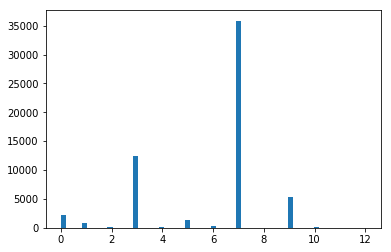

Taking action: 3
Moving to state: 0


(-80, True)

In [13]:
# Check that the tree runs simulations to choose the next action

print("INITIAL STATE: ")
print(str(s)+' '+game.StateNames[s]) # initial block game state


obs = []

action = agent.search(obs)
print("Taking action:", action)
state = game.next_state(s,action)
print("Moving to state:", state)
game.reward(s,action)

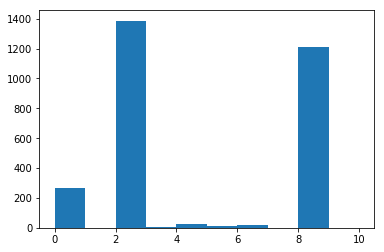

Taking action: [2, 'b', 'g']
Moving to state: 0


In [84]:
obs = game.observation(state,action)
action = agent.search(obs)
print("Taking action:", action)
r = game.reward(state,action)
state = game.next_state(state,action)
print("Moving to state:", state)


INITIAL STATE: 
0 r,g,b
TARGET: 
['rgb', 'rbg', 'grb', 'gbr', 'brg', 'bgr']
tree is none


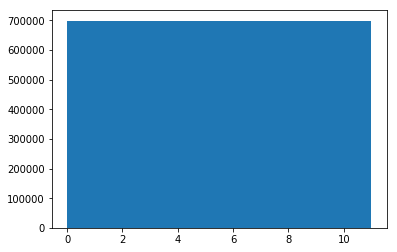

Action 1: True state is 0, r,g,b
Taking action 3.
game over!
total reward:  -80


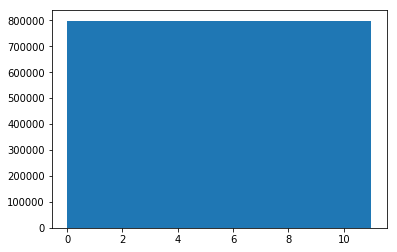

In [11]:
# if 'game' in locals():
#     del game
# if 'agent' in locals():
# #     del agent
del game
del agent

s = 0
target = ['rgb','rbg','grb','gbr','brg','bgr']
game = BlockGame(target)

c = 1

print("INITIAL STATE: ")
print(str(s)+' '+game.StateNames[s]) # initial tiger state
print("TARGET: ")
print(target)

agent = POMCP(game, 0.9, c, maxdepth=10, nsims=10000)

action_seq = []
state = s
obs = []
R = 0


while len(action_seq) <= 20: # play for a certain amount of time (better rule?)

    action = agent.search(obs)
    action_seq.append(action)
    print('Action %i: True state is %s, %s'% (len(action_seq), state, game.StateNames[state]))
    print("Taking action %s."% action)
    
    obs = game.observation(state,action)
    if obs!=[]:
        print("observed ",obs)

    r,done = game.reward(state,action)
    if done:
        R=R+r
        break
    R = R + r
    print("Reward so far: ",R)    
    
    state = game.next_state(state,action)
    


print("game over!")
print('total reward: ', R)
plt.hist(agent.tree.children[0].belief,bins='auto')
plt.show()

In [6]:
for i in agent.tree.children[0].children:
    print("action: ",i.action)#agent.tree.children[0].children[i].action)
    print("value: ",i.value)#agent.tree.children[0].children[i].value)

action:  [0, 'r', 'g']
value:  0
action:  [0, 'r', 'b']
value:  0
action:  [0, 'g', 'r']
value:  0
action:  [0, 'g', 'b']
value:  0
action:  [0, 'b', 'r']
value:  0
action:  [0, 'b', 'g']
value:  0
action:  [1, 'r', 'g']
value:  0
action:  [1, 'r', 'b']
value:  0
action:  [1, 'g', 'r']
value:  0
action:  [1, 'g', 'b']
value:  0
action:  [1, 'b', 'r']
value:  0
action:  [1, 'b', 'g']
value:  0
action:  [2, 'r', 'g']
value:  0
action:  [2, 'r', 'b']
value:  0
action:  [2, 'g', 'r']
value:  0
action:  [2, 'g', 'b']
value:  0
action:  [2, 'b', 'r']
value:  0
action:  [2, 'b', 'g']
value:  0
action:  3
value:  547.1450547967871


In [64]:
game.next_state(0,[0,'b','g'])

2

In [30]:
put_acts = [[0,'r','g'],[0,'r','b'],[0,'g','r'],[0,'g','b'],[0,'b','r'],[0,'b','g']]
take_acts = [[1,'r','g'],[1,'r','b'],[1,'g','r'],[1,'g','b'],[1,'b','r'],[1,'b','g']]
ask_acts = [[2,'r','g'],[2,'r','b'],[2,'g','r'],[2,'g','b'],[2,'b','r'],[2,'b','g']]
check = [3] # submit for checking if correct
legal = [put_acts[4]] + [take_acts[0]] + ask_acts + check
legal

[[0, 'b', 'r'],
 [1, 'r', 'g'],
 [2, 'r', 'g'],
 [2, 'r', 'b'],
 [2, 'g', 'r'],
 [2, 'g', 'b'],
 [2, 'b', 'r'],
 [2, 'b', 'g'],
 3]

In [75]:
s = 'rgb'
x=2
y=3
game.StateNames.index(s[0] + ',' + s[1:])

1

In [78]:
np.random.randint(13)

10

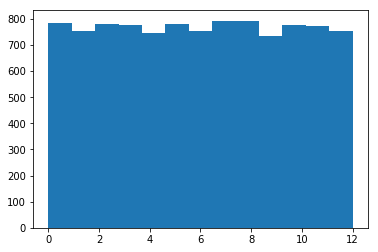

In [31]:
plt.hist(np.random.randint(13, size=10000),bins=13)
plt.show()

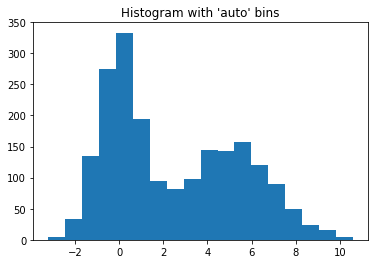

In [18]:
import matplotlib.pyplot as plt
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))
plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [19]:
# can i do a value iteration algorithm for POMDP?

# lol no 
def get_value(a,t,prior,gamma):
    if t==1:
        
    val = val + gamma*get_value(a,t-1,prior,gamma)
    return 

IndentationError: expected an indented block (<ipython-input-19-1c8266003346>, line 7)